In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom

In [2]:
# создаём красивый дизайн для графиков
sns.set(rc={'figure.figsize': (9, 6)})

In [3]:
events_data = pd.read_csv('E:\Курсы, которые прохожу СЕЙЧАС\Введение в Data Science и машинное обучение\Project csv\event_data_train.csv')
events_data

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


In [4]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480703 entries, 0 to 3480702
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   step_id    int64 
 1   timestamp  int64 
 2   action     object
 3   user_id    int64 
dtypes: int64(3), object(1)
memory usage: 106.2+ MB


In [5]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


### Время в секундах прошедшее с 1 января 1970 года [Unix-время](https://ru.wikipedia.org/wiki/Unix-время)

### 1. Проверяем данные

In [6]:
events_data.action.value_counts()

viewed             1830830
discovered          689495
passed              650331
started_attempt     310047
Name: action, dtype: int64

In [7]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

#### преобразуем время в дату

In [8]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


# [pandas.to_datetime](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)

In [9]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [10]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [11]:
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


# [pandas.Series.dt](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.html)

In [12]:
# количество людей, которые присоединились к курсу
events_data.groupby('day').user_id.nunique().head()

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
Name: user_id, dtype: int64

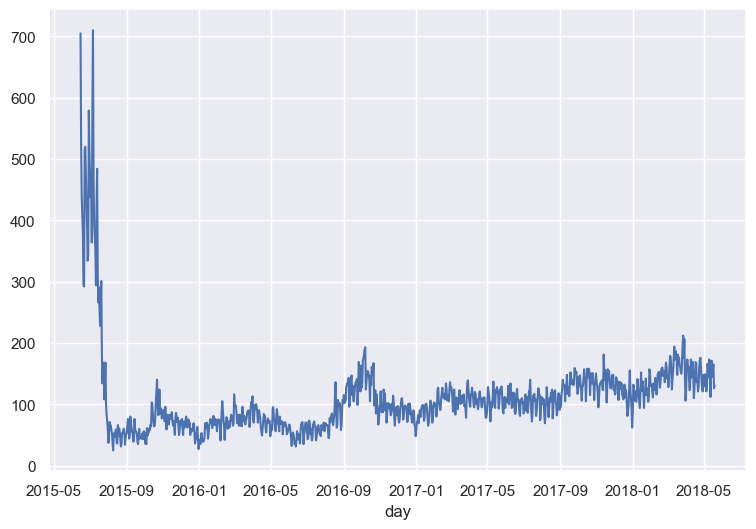

In [13]:
events_data.groupby('day').user_id.nunique().plot();

In [14]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'})

,user_id,passed_steps
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84
...,...,...
17257,26789,2
17258,26790,8
17259,26794,69
17260,26797,10


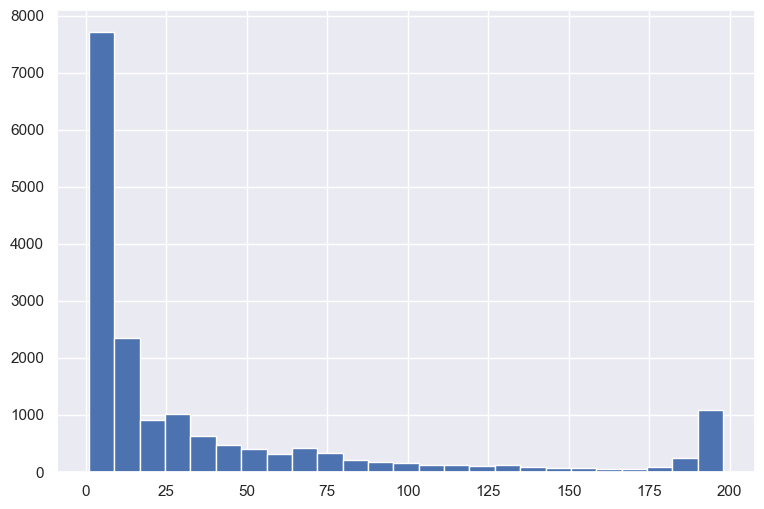

In [15]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}) \
    .passed_steps.hist(bins=25);

#### Проблема в том, что мы не учитываем пользователей, которые ни решили ни одной задачки, а только зарегистрировались на курс

# Нужно постоянно себя валидировать на каждом этапе!

In [16]:
events_data.pivot_table(index='user_id', columns='action', values='step_id',
                        aggfunc='count', fill_value=0)

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1
...,...,...,...,...
26790,8,8,1,9
26793,1,0,1,1
26794,69,69,34,180


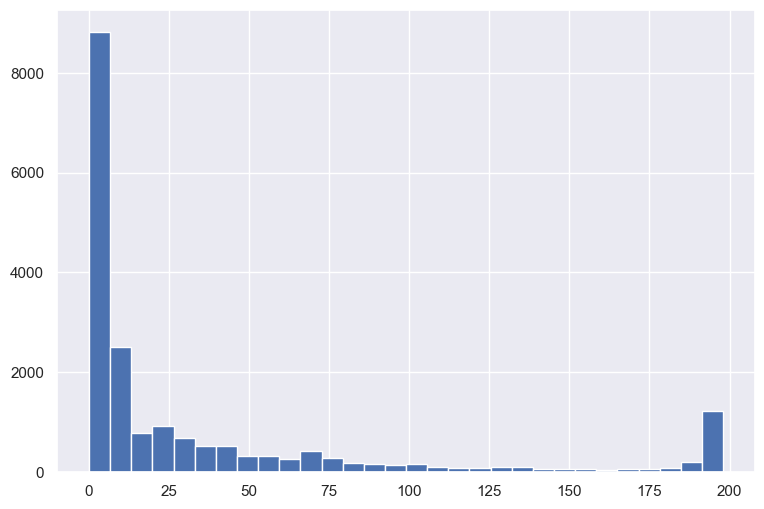

In [17]:
events_data.pivot_table(index='user_id', columns='action', values='step_id',
                        aggfunc='count', fill_value=0).reset_index().discovered.hist(bins=30);

# [pandas.pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)

### data preprocessing - предворительная подготовка данных

In [18]:
submit = pd.read_csv('E:\Курсы, которые прохожу СЕЙЧАС\Введение в Data Science и машинное обучение\Project csv\submissions_data_train.csv')
submit

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [19]:
submit['date'] = pd.to_datetime(arg=submit['timestamp'], unit='s')
submit['day'] = submit['date'].dt.date

In [20]:
submit

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [21]:
users_scores = submit.pivot_table(index='user_id',
                  columns='submission_status',
                                 values='step_id',
                                 aggfunc='count',
                                 fill_value=0).reset_index()

In [22]:
users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [23]:
# Каждый список - это совокупность точек во времени, когда совершалась активность
events_data[['user_id', 'day', 'timestamp']] \
    .drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list)

user_id
1                                             [1472827464]
2                                 [1514383364, 1519226966]
3        [1434358476, 1441257725, 1441440209, 144153391...
5                                 [1466156809, 1499859621]
7                                             [1521634660]
                               ...                        
26790     [1451484016, 1451722241, 1452616205, 1517495853]
26793                                         [1510225031]
26794    [1495287049, 1495373177, 1495509936, 149560483...
26797                             [1508425316, 1509993306]
26798                                         [1520975763]
Name: timestamp, Length: 19234, dtype: object

# [pandas.DataFrame.drop_duplicates](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)

In [24]:
events_data[['user_id', 'day', 'timestamp']] \
    .drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff)

user_id
1                                                       []
2                                                [4843602]
3         [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                               [33702812]
7                                                       []
                               ...                        
26790                           [238225, 893964, 64879648]
26793                                                   []
26794    [86128, 136759, 94899, 1422583, 14347289, 5050...
26797                                            [1567990]
26798                                                   []
Name: timestamp, Length: 19234, dtype: object

# [numpy.diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html#)

In [25]:
# созраняем в array
gap_data = events_data[['user_id', 'day', 'timestamp']] \
    .drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [26]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data.head()

0    4843602
1    6899249
2     182484
3      93710
4    2768870
dtype: int32

In [27]:
gap_day_data = gap_data / 86400  # разница в днях среди пользователей

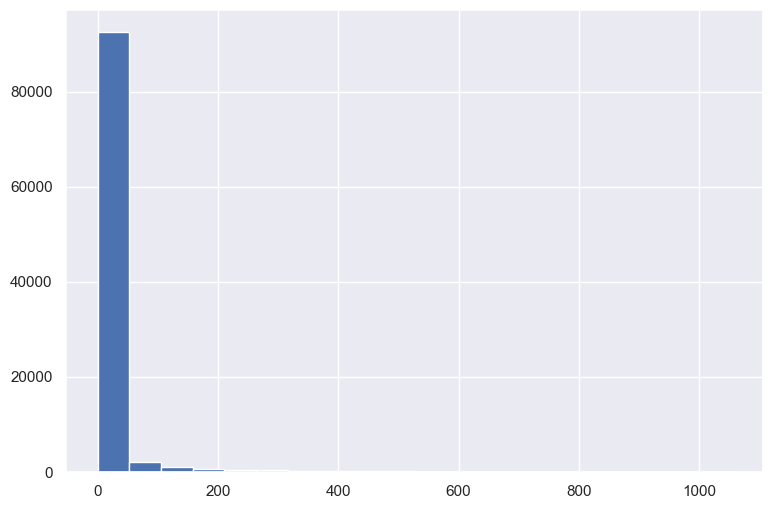

In [28]:
gap_day_data.hist(bins=20);

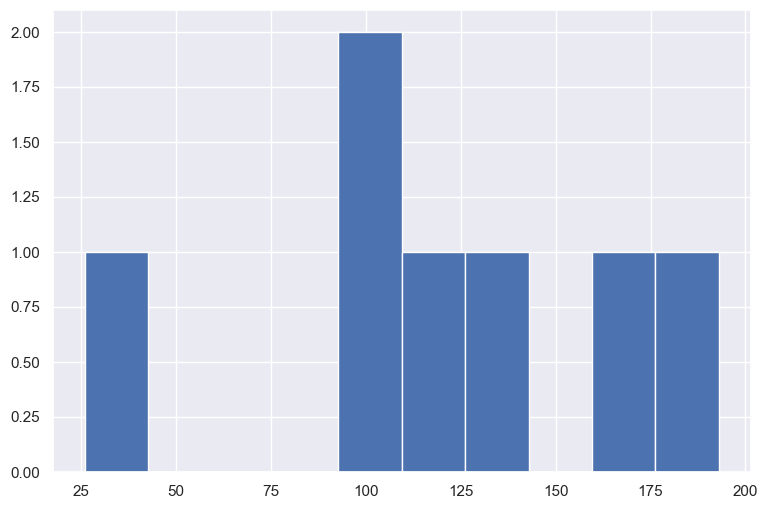

In [29]:
gap_data[gap_data < 200].hist();

In [30]:
gap_data.quantile(0.95) / 86400

59.760440972222156

# Найдём id Анатолия

In [31]:
users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [32]:
users_scores.sort_values(by='correct', ascending=False)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42
...,...,...,...
551,1321,0,2
9778,26349,0,1
3559,9422,0,1
5014,13408,0,2


In [33]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [34]:
# для каждого пользователя последнее время захода на сайт
visits = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_visit'})

In [35]:
red_line = 30 * 86400  # 30 days deadline
last_view = 1526772811

In [36]:
# if is_gone_user then this user dropped the course(
visits['is_gone_user'] = last_view - visits['last_visit'] > red_line
visits.head()

,user_id,last_visit,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [37]:
users_data = visits.merge(users_scores, on='user_id', how='outer')

In [38]:
users_data.fillna(0)
users_data

,user_id,last_visit,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,NaN,NaN
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [39]:
users_events_data = events_data.pivot_table(index='user_id', columns='action', values='step_id',
                        aggfunc='count', fill_value=0).reset_index()

In [40]:
users_data = users_data.merge(users_events_data, how='outer')
users_data.head()

,user_id,last_visit,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,NaN,NaN,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,NaN,NaN,1,1,0,1


In [41]:
users_days = events_data.groupby('user_id').day.nunique()

In [42]:
# количество уникальных дней для каждого пользователя
users_days = users_days.to_frame().reset_index()
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


# [pandas.Series.to_frame](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_frame.html)

In [43]:
users_data = users_data.merge(users_days, how='outer')
users_data

,user_id,last_visit,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,NaN,NaN,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,NaN,NaN,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,NaN,NaN,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


In [44]:
# смотрим количество пользователей
users_data.user_id.nunique()

19234

In [45]:
events_data.user_id.nunique()

19234

In [46]:
# количество пользователей набравших более 170 шагов
users_data['passed'][users_data.passed > 170].count()

1425

In [47]:
users_data['passed_course'] = users_data.passed > 170
users_data.passed_course.value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_course, dtype: float64